In [103]:
import squidpy as sq
import scanpy as sc
import scvelo as scv
import numpy as np
import sys

In [104]:
adata = sq.datasets.visium_hne_adata()
adata = adata[:,adata.var.highly_variable][:,0:1000].copy()
adata.var.index = np.char.upper(adata.var.index.values.astype(str))
adata.write("./../../test_adata.h5ad")

adata.obs["Cell"] = adata.obs.index
adata.obs[["Cell","cluster"]].to_csv("./../../test_meta.txt", sep="\t", index=False)

adata_df = adata.T.to_df()
adata_df.index.rename("Gene", inplace=True)
adata_df.to_csv("./../../test_adata.txt", sep="\t")

Run the cellphonedb analysis from command line

```
cellphonedb method statistical_analysis test_meta.txt test_adata.txt --output-path="./output" --iterations=1000 --threads=6 --threshold=0.1 --verbose --counts-data hgnc_symbol
```

In [106]:
# or alt. clone the cpdb repo and move this notebook into the repo's root
if False:
    sys.path.insert(0, "./cellphonedb/src/api_endpoints/terminal_api/method_terminal_api_endpoints/")
    from method_terminal_commands import statistical_analysis

    statistical_analysis("./../../test_meta.txt", "./../../test_adata.txt", iterations=1000, threads=6, threshold=0.1, verbose=True,
                         counts_data="gene_name")

In [107]:
adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
OPRK1,ENSMUSG00000025905,Gene Expression,mm10,False,324,0.171609,0.158378,87.991105,463.0,6.139884,324,True,1577.0,0.172247,0.303405,1.361687
ST18,ENSMUSG00000033740,Gene Expression,mm10,False,415,0.209785,0.190443,84.618236,566.0,6.340359,414,True,1364.0,0.209821,0.389900,1.432583
3110035E14RIK,ENSMUSG00000067879,Gene Expression,mm10,False,1816,3.743514,1.556778,32.690882,10100.0,9.220389,1814,True,223.0,3.756324,41.699811,3.539194
1700034P13RIK,ENSMUSG00000097893,Gene Expression,mm10,False,12,0.005189,0.005176,99.555226,14.0,2.708050,12,True,2418.0,0.005208,0.006672,1.185924
SGK3,ENSMUSG00000025915,Gene Expression,mm10,False,553,0.266123,0.235960,79.503336,718.0,6.577861,553,True,2679.0,0.267113,0.405736,1.148363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM68,ENSMUSG00000028232,Gene Expression,mm10,False,1215,0.759081,0.564791,54.966642,2048.0,7.625107,1215,True,2881.0,0.761905,1.306148,1.126341
PENK,ENSMUSG00000045573,Gene Expression,mm10,False,1364,3.696812,1.546884,49.444033,9974.0,9.207837,1363,True,22.0,3.710193,131.140023,11.358528
FAM110B,ENSMUSG00000049119,Gene Expression,mm10,False,1462,1.007784,0.697031,45.811712,2719.0,7.908387,1462,True,3613.0,1.011533,1.770243,1.064102
SDCBP,ENSMUSG00000028249,Gene Expression,mm10,False,2376,3.751668,1.558496,11.934766,10122.0,9.222566,2373,True,1178.0,3.764509,18.005930,1.522757


In [108]:
adata.obs.cluster.cat.categories

Index(['Cortex_1', 'Cortex_2', 'Cortex_3', 'Cortex_4', 'Cortex_5',
       'Fiber_tract', 'Hippocampus', 'Hypothalamus_1', 'Hypothalamus_2',
       'Lateral_ventricle', 'Pyramidal_layer', 'Pyramidal_layer_dentate_gyrus',
       'Striatum', 'Thalamus_1', 'Thalamus_2'],
      dtype='object')

In [176]:
import re
import os
import pandas as pd
datadir = 'out'
files = os.listdir(datadir)

class cpdb:
    def __init__(self, datadir):
        files = os.listdir(datadir)
        means = pd.read_csv([datadir +'/'+i for i in files if re.search('^means', i)][0])
        pvalues = pd.read_csv([datadir +'/'+i for i in files if re.search('^pvalues', i)][0])
        res2 = {}
        cols = ()
        rows = ()
        for x in means.iloc[:, 11:].columns:
            cols = cols + (tuple(x.split('|')),)
            columns = pd.MultiIndex.from_tuples(cols, names=["cluster_1", "cluster_2"])

        for x in means['interacting_pair']:
            rows = rows + (tuple(x.split('_')),)
        index = pd.MultiIndex.from_tuples(rows, names=["source", "target"])
        means = pd.DataFrame(np.array(means.iloc[:,11:]), index = index, columns = columns)
        pvalues = pd.DataFrame(np.array(pvalues.iloc[:,11:]), index = index, columns = columns)
        pvalues[np.isclose(pvalues, 1.0)] = np.nan
        pvalues[np.isclose(pvalues, 0.0)] = 0.001 # since i only did 1k iterations
        self.means = means
        self.pvalues = pvalues

def CellPhoneResults(datadirs):
    return(cpdb(datadirs).__dict__)

In [177]:
original_cpdb_results = CellPhoneResults(datadir)

In [178]:
res = sq.gr.ligrec(
    adata,
    n_perms=1000,
    cluster_key="cluster",
    copy=True,
    use_raw=False,
    interactions=list(original_cpdb_results['pvalues'].index),
    # interactions_params={'resources': 'CellPhoneDB'},
    threshold=0.1,
    n_jobs = 6)

  0%|          | 0/1000 [00:00<?, ?permutation/s]

Text(0.5, 0, 'theirs')

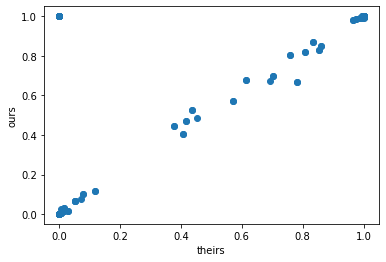

In [179]:
np.testing.assert_allclose(original_cpdb_results['means'].values[0],
                           res['means'].values[0], rtol=1e-5, atol=1e-3)
plt.scatter(
    original_cpdb_results['pvalues'].fillna(1.0).values[0],
    res['pvalues'].fillna(1.0).values[0]
)
plt.ylabel("ours")
plt.xlabel("theirs")

In [180]:
original_cpdb_results['pvalues']

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.694    0.030    0.018    0.054      NaN         NaN   
BDNF   SORT1     0.001    0.197    0.202    0.001      NaN       0.048   
       F11R        NaN    0.982      NaN      NaN    0.976       0.983   
EFNA3  EPHA4     0.001    0.024    0.845    0.001    0.947         NaN   
EFNA4  EPHA4       NaN      NaN      NaN      NaN      NaN         NaN   
PTPRC  MRC1        NaN      NaN      NaN      NaN      NaN         NaN   
SELL   CD34        NaN      NaN      NaN      NaN      NaN         NaN   
NPR1   NPPC        NaN      NaN      NaN      NaN      NaN         NaN   
QRFP   QRFPR       NaN      NaN      NaN      NaN      NaN         NaN   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM          NaN          0.001          0.571               NaN   
BDNF   SORT1          NaN            NaN            NaN               NaN   
       F11R         0.893          0.994          0.911             0.001   
EFNA3  EPHA4        0.006            NaN          0.988               NaN   
EFNA4  EPHA4          NaN            NaN            NaN               NaN   
PTPRC  MRC1           NaN            NaN            NaN               NaN   
SELL   CD34           NaN            NaN            NaN               NaN   
NPR1   NPPC           NaN            NaN            NaN               NaN   
QRFP   QRFPR          NaN            NaN            NaN               NaN   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.976       0.834          0.001          0.001   
BDNF   SORT1   ...       0.001       0.910            NaN            NaN   
       F11R    ...       0.001       0.001          0.001          0.006   
EFNA3  EPHA4   ...         NaN       0.482            NaN            NaN   
EFNA4  EPHA4   ...         NaN         NaN            NaN            NaN   
PTPRC  MRC1    ...         NaN         NaN            NaN            NaN   
SELL   CD34    ...         NaN         NaN            NaN            NaN   
NPR1   NPPC    ...         NaN         NaN            NaN            NaN   
QRFP   QRFPR   ...         NaN         NaN            NaN            NaN   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.701           0.001                         0.006   
BDNF   SORT1                NaN           0.001                         0.001   
       F11R               0.001           0.065                         0.030   
EFNA3  EPHA4                NaN           0.001                         0.001   
EFNA4  EPHA4                NaN             NaN                           NaN   
PTPRC  MRC1                 NaN             NaN                           NaN   
SELL   CD34                 NaN             NaN                           NaN   
NPR1   NPPC                 NaN             NaN                           NaN   
QRFP   QRFPR                NaN             NaN                           NaN   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM     0.001      0.001      0.001  
BDNF   SORT1     0.976      0.001        NaN  
       F11R      0.012      0.001      0.001  
EFNA3  EPHA4      

In [181]:
res['pvalues']

cluster_1     Cortex_1                                                  \
cluster_2     Cortex_1 Cortex_2 Cortex_3 Cortex_4 Cortex_5 Fiber_tract   
source target                                                            
L1CAM  L1CAM     0.672    0.018    0.014    0.064    1.000       1.000   
BDNF   SORT1       NaN    0.207    0.225      NaN    1.000       0.054   
       F11R      1.000    0.992    1.000    1.000    0.996       0.980   
EFNA3  EPHA4       NaN    0.042    0.843      NaN    0.934       1.000   
EFNA4  EPHA4       NaN      NaN      NaN      NaN      NaN         NaN   
PTPRC  MRC1        NaN      NaN      NaN      NaN      NaN         NaN   
SELL   CD34        NaN      NaN      NaN      NaN      NaN         NaN   
NPR1   NPPC        NaN      NaN      NaN      NaN      NaN         NaN   
QRFP   QRFPR       NaN      NaN      NaN      NaN      NaN         NaN   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
L1CAM  L1CAM        1.000            NaN          0.574               1.0   
BDNF   SORT1        1.000          1.000          1.000               1.0   
       F11R         0.919          0.996          0.962               NaN   
EFNA3  EPHA4        0.004          1.000          0.988               1.0   
EFNA4  EPHA4          NaN            NaN            NaN               NaN   
PTPRC  MRC1           NaN            NaN            NaN               NaN   
SELL   CD34           NaN            NaN            NaN               NaN   
NPR1   NPPC           NaN            NaN            NaN               NaN   
QRFP   QRFPR          NaN            NaN            NaN               NaN   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
L1CAM  L1CAM   ...       0.986       0.868            NaN            NaN   
BDNF   SORT1   ...         NaN       0.923          1.000          0.978   
       F11R    ...         NaN         NaN          0.001          0.001   
EFNA3  EPHA4   ...       1.000       0.469          1.000          1.000   
EFNA4  EPHA4   ...         NaN         NaN            NaN            NaN   
PTPRC  MRC1    ...         NaN         NaN            NaN            NaN   
SELL   CD34    ...         NaN         NaN            NaN            NaN   
NPR1   NPPC    ...         NaN         NaN            NaN            NaN   
QRFP   QRFPR   ...         NaN         NaN            NaN            NaN   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
L1CAM  L1CAM              0.700             NaN                         0.005   
BDNF   SORT1              0.999             NaN                           NaN   
       F11R                 NaN           0.069                         0.050   
EFNA3  EPHA4              1.000             NaN                           NaN   
EFNA4  EPHA4                NaN             NaN                           NaN   
PTPRC  MRC1                 NaN             NaN                           NaN   
SELL   CD34                 NaN             NaN                           NaN   
NPR1   NPPC                 NaN             NaN                           NaN   
QRFP   QRFPR                NaN             NaN                           NaN   

cluster_1                                     
cluster_2     Striatum Thalamus_1 Thalamus_2  
source target                                 
L1CAM  L1CAM       NaN        NaN        NaN  
BDNF   SORT1     0.995        NaN      1.000  
       F11R      0.006        NaN      0.001  
EFNA3  EPHA4     1

In [182]:
res['pvalues'][('Pyramidal_layer', 'Hypothalamus_2')]

source  target
L1CAM   L1CAM     0.1
BDNF    SORT1     0.1
        F11R      NaN
EFNA3   EPHA4     NaN
EFNA4   EPHA4     NaN
PTPRC   MRC1      NaN
SELL    CD34      NaN
NPR1    NPPC      NaN
QRFP    QRFPR     NaN
Name: (Pyramidal_layer, Hypothalamus_2), dtype: Sparse[float64, nan]

In [183]:
original_cpdb_results['pvalues'][('Pyramidal_layer', 'Hypothalamus_2')]

source  target
L1CAM   L1CAM     0.078
BDNF    SORT1     0.100
        F11R      0.001
EFNA3   EPHA4     0.001
EFNA4   EPHA4       NaN
PTPRC   MRC1        NaN
SELL    CD34        NaN
NPR1    NPPC        NaN
QRFP    QRFPR       NaN
Name: (Pyramidal_layer, Hypothalamus_2), dtype: float64

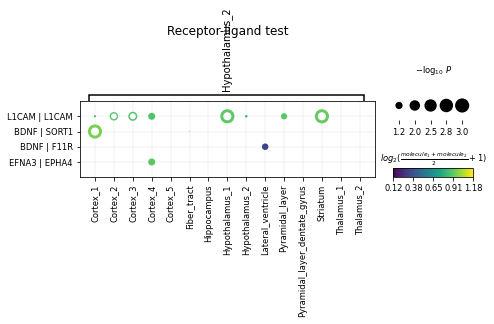

In [184]:
sq.pl.ligrec(res, source_groups="Hypothalamus_2", alpha=0.05)

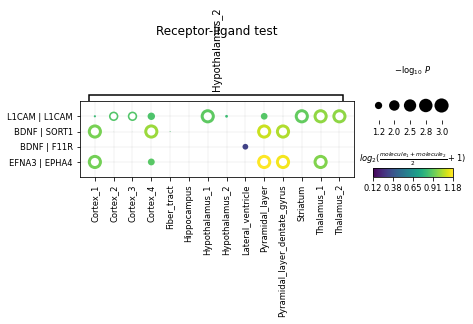

In [185]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_2", alpha=0.05)

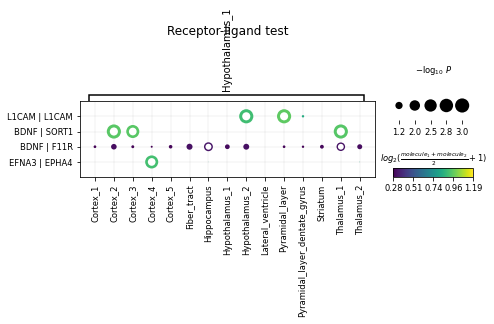

In [186]:
sq.pl.ligrec(res, source_groups="Hypothalamus_1", alpha=0.05,)

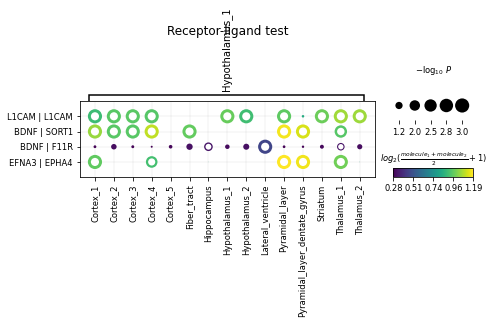

In [42]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_1", alpha=0.05)

In [51]:
res["means"]

cluster_1      Cortex_1                                                      \
cluster_2      Cortex_1  Cortex_2  Cortex_3  Cortex_4  Cortex_5 Fiber_tract   
source target                                                                 
NPPC   NPR1    0.121109  0.130683  0.121975  0.124185  0.131934    0.166381   
QRFP   QRFPR   0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
BMP7   ACVR2A  0.213889  0.356070  0.231769  0.260584  0.238752    0.103640   
IL7    IL2RG   0.009020  0.005502  0.008354  0.006813  0.016460    0.010901   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
NPPC   NPR1      0.127520       0.130540       0.148737          0.197150   
QRFP   QRFPR     0.000000       0.000000       0.000000          0.000000   
BMP7   ACVR2A    0.106134       0.161225       0.122098          0.163308   
IL7    IL2RG     0.004781       0.009324       0.012746          0.043537   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
NPPC   NPR1    ...    0.122519    0.083657       0.086677       0.104875   
QRFP   QRFPR   ...    0.000000    0.000000       0.000000       0.000000   
BMP7   ACVR2A  ...    0.106876    0.109369       0.164460       0.125334   
IL7    IL2RG   ...    0.016486    0.010366       0.014909       0.018330   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
NPPC   NPR1            0.153287        0.109735                      0.143877   
QRFP   QRFPR           0.000000        0.000000                      0.000000   
BMP7   ACVR2A          0.166543        0.156306                      0.254942   
IL7    IL2RG           0.049122        0.010025                      0.018394   

cluster_1                                      
cluster_2      Striatum Thalamus_1 Thalamus_2  
source target                                  
NPPC   NPR1    0.096979   0.128907   0.100748  
QRFP   QRFPR   0.000000   0.000000   0.000000  
BMP7   ACVR2A  0.293011   0.128185   0.163559  
IL7    IL2RG   0.000000   0.017810   0.018033  

[4 rows x 225 columns]